Starting the full ML pipeline (Strategy: LightGBM ONLY)...
Original train data shape: (5000, 20)
Original test data shape: (500, 19)
Found 493 rows with non-positive cost. Setting them to 0.
Combined data shape for preprocessing: (5500, 20)
Starting feature engineering...
Created 'Is_Missing' flags for these columns.
Feature engineering complete.
Building preprocessing pipeline...
Final shapes: X=(5000, 26), y=(5000,), X_test=(500, 26)

--- Starting Model Tuning for LightGBM ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2519
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 25
[LightGBM] [Info] Start training from score 5.944849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

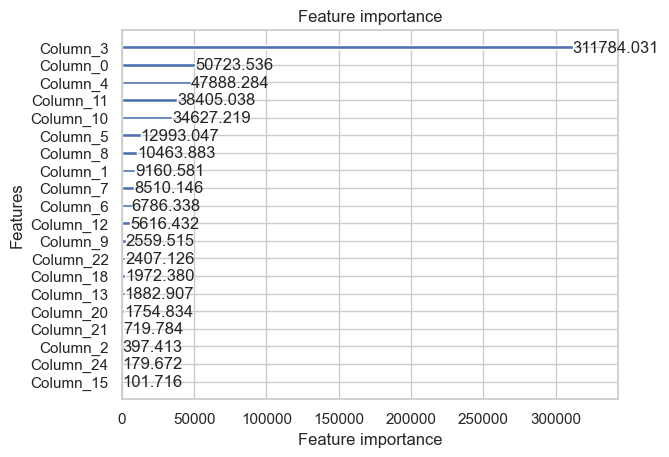

In [1]:
print("Starting the full ML pipeline (Strategy: LightGBM ONLY)...")
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import warnings
from sklearn.preprocessing import RobustScaler

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

#Load Data
try:
    train_df_raw = pd.read_csv("train.csv")
    test_df_raw = pd.read_csv("test.csv")
except FileNotFoundError:
    print("Trying alternative path")
    try:
        train_df_raw = pd.read_csv("train.csv")
        test_df_raw = pd.read_csv("test.csv")
    except Exception as e:
        print(f"FATAL ERROR: Could not find train.csv or test.csv. {e}")
        raise

print(f"Original train data shape: {train_df_raw.shape}")
print(f"Original test data shape: {test_df_raw.shape}")

test_hospital_ids = test_df_raw['Hospital_Id']

#Clean Target Variable & Log Transform
target = train_df_raw['Transport_Cost'].copy()
invalid_cost_indices = target[target <= 0].index
print(f"Found {len(invalid_cost_indices)} rows with non-positive cost. Setting them to 0.")
target.loc[invalid_cost_indices] = 0
target_log = np.log1p(target)

train_df_processed = train_df_raw.drop('Transport_Cost', axis=1)
train_df_processed['source'] = 'train'
test_df_raw['source'] = 'test'
df = pd.concat([train_df_processed, test_df_raw], ignore_index=True)
print(f"Combined data shape for preprocessing: {df.shape}")

#Feature Engineering
 # 2. We find all columns that have any missing data
missing_cols = [
    'Supplier_Reliability',
    'Equipment_Height',
    'Equipment_Width',
    'Equipment_Weight',
    'Equipment_Type',
    'Transport_Method',
    'Rural_Hospital'
]
def preprocess_features(df_to_process):
    print("Starting feature engineering...")
    df_processed = df_to_process.copy()
    df_processed = df_processed.drop(['Supplier_Name'], axis=1)

   

    # Create binary indicators (1 = missing, 0 = not missing)
    for col in missing_cols:
        df_processed[col + '_Is_Missing'] = df_processed[col].isnull().astype(int)
    print(f"Created 'Is_Missing' flags for these columns.")
    
    # Date Features
    df_processed['Order_Placed_Date'] = pd.to_datetime(df_processed['Order_Placed_Date'])
    df_processed['Delivery_Date'] = pd.to_datetime(df_processed['Delivery_Date'])
    df_processed['Delivery_Time_Days'] = (df_processed['Delivery_Date'] - df_processed['Order_Placed_Date']).dt.days.clip(lower=0)
    #df_processed['Order_Year'] = df_processed['Order_Placed_Date'].dt.year
    #df_processed['Order_Month'] = df_processed['Order_Placed_Date'].dt.month
    #df_processed['Order_DayOfWeek'] = df_processed['Order_Placed_Date'].dt.dayofweek
    df_processed = df_processed.drop(['Order_Placed_Date', 'Delivery_Date'], axis=1)

    # Location Features
    df_processed['Hospital_State'] = df_processed['Hospital_Location'].str.split(',').str[1].str.strip().str.split(' ').str[0]
    df_processed['Hospital_State'] = df_processed['Hospital_State'].fillna('Unknown')
    df_processed = df_processed.drop('Hospital_Location', axis=1)

    # Binary Features
    binary_cols = ['CrossBorder_Shipping', 'Urgent_Shipping', 'Installation_Service', 
                   'Fragile_Equipment', 'Rural_Hospital','Hospital_Info']
    for col in binary_cols:
        df_processed[col] = df_processed[col].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)

    #Interaction Features
    df_processed['Equipment_Height'] = df_processed['Equipment_Height'].fillna(1)
    df_processed['Equipment_Width'] = df_processed['Equipment_Width'].fillna(1)
    df_processed['Equipment_Weight'] = df_processed['Equipment_Weight'].fillna(0)
    df_processed['Equipment_Value'] = df_processed['Equipment_Value'].fillna(0)

    df_processed['Equipment_Area'] = df_processed['Equipment_Height'] * df_processed['Equipment_Width']
    df_processed['Value_Density'] = df_processed['Equipment_Value'] / (df_processed['Equipment_Weight'] + 1e-6)
    df_processed["Value_per_Height"] = df_processed["Equipment_Value"] / (df_processed["Equipment_Height"] + 1e-6)
    df_processed["Value_per_Width"] = df_processed["Equipment_Value"] / (df_processed["Equipment_Width"] + 1e-6)
    df_processed["Weight_per_Area"] = df_processed["Equipment_Weight"] / (df_processed["Equipment_Area"] + 1e-6)
    df_processed["Cost_per_Day"] = df_processed["Base_Transport_Fee"] / (df_processed["Delivery_Time_Days"] + 1)
    df_processed["Value_per_Area"] = df_processed["Equipment_Value"] / (df_processed["Equipment_Area"] + 1e-6)
    


    print("Feature engineering complete.")
    return df_processed

df_featured = preprocess_features(df)
missing_flag_features = [col + '_Is_Missing' for col in missing_cols]
#Preprocessing Pipeline
print("Building preprocessing pipeline...")

numeric_features = ['Supplier_Reliability',"Cost_per_Day"]
skewed_features = [ 'Equipment_Value', 'Base_Transport_Fee', 'Value_Density','Equipment_Width','Equipment_Height',
                   'Equipment_Area',"Value_per_Area","Value_per_Height","Value_per_Width","Weight_per_Area"
                  ]
categorical_features = ['Equipment_Type', 'Transport_Method']
binary_features = [
                   'Fragile_Equipment', 'Rural_Hospital','Hospital_Info']
binary_features=binary_features 

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    #('scaler',  RobustScaler())
])

skewed_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('log_transform', FunctionTransformer(np.log1p, validate=False))
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('skew', skewed_pipeline, skewed_features),
        ('cat', categorical_pipeline, categorical_features),
        ('binary', 'passthrough', binary_features)
    ],
    remainder='drop',
    n_jobs=1
)

#Apply Preprocessing
df_to_transform = df_featured.drop(['Hospital_Id', 'source'], axis=1)
train_mask = df_featured['source'] == 'train'
preprocessor.fit(df_to_transform[train_mask])
df_final = preprocessor.transform(df_to_transform)

train_mask_numpy = train_mask.values
X = df_final[train_mask_numpy]
X_test = df_final[~train_mask_numpy]
y = target_log.reset_index(drop=True)

print(f"Final shapes: X={X.shape}, y={y.shape}, X_test={X_test.shape}")
# Suppose y is your target (Log_Transport_Cost)
#num_bins = 10  # 10 bins based on quantiles
#y_binned = pd.qcut(y, q=num_bins, labels=False, duplicates='drop')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#LightGBM Model
print("\n--- Starting Model Tuning for LightGBM ---")

lgb_model = lgb.LGBMRegressor(
    objective='regression',
    
    random_state=42,
    n_jobs=-1
)


param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 400, 600, 800],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.3, 0.5, 1],
    'reg_lambda': [0, 0.5, 1, 2, 5],
    'min_split_gain': [0, 0.01, 0.05],
    'num_leaves': [31, 63, 127],
    'max_depth': [5, 7, 9]
}

search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    n_iter=25,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
print(f"Best parameters: {search.best_params_}")


#Evaluate on Validation Set
y_pred_log = best_model.predict(X_val)
y_pred_actual = np.expm1(y_pred_log)
y_val_actual = np.expm1(y_val)
rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred_actual))
print(f"\nLightGBM RMSE (on validation): {rmse:.2f}")
mse=mean_squared_error(y_val_actual, y_pred_actual)
print(f"\nLightGBM MSE (on validation): {mse:.2f}")
lgb.plot_importance(best_model, max_num_features=20, importance_type='gain')

#Retrain on Full Data
print("Retraining LightGBM on full training data...")
best_model.fit(X, y)

#Predict on Test Data
test_pred_log = best_model.predict(X_test)
test_pred_actual = np.expm1(test_pred_log)
test_pred_actual[test_pred_actual < 0] = 0  # Safety clip

submission_df = pd.DataFrame({
    'Hospital_Id': test_hospital_ids,
    'Transport_Cost': test_pred_actual
})

submission_df.to_csv('submission_LIGHTGBM_ONLY_model.csv', index=False)

print("\n--- DONE ---")
print("Submission file 'submission_LIGHTGBM_ONLY_model.csv' created successfully.")
print(submission_df.head())